# k-means
### Modelo 03
- TfidfVectorizer
- Base A


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_a.csv')

df.head()

,nome,categoria
0,1051 SUCO DE UVA,SUCO UVA
1,110 PEPSI LIGHT,PEPSI
2,2L COCA COLA,COCA-COLA
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,SPRITE
4,AGUA SPRITE,SPRITE


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,1051 SUCO DE UVA,13
1,110 PEPSI LIGHT,8
2,2L COCA COLA,2
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,10
4,AGUA SPRITE,10


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Separa base de treino e teste

In [5]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome,
    df.categoria,
    test_size = 0.3,
    random_state = 42
)

#### Define TfidfVectorizer

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=token,
    ngram_range=(1,3)
)

#### Cria vocabulário

In [7]:
X_train = tfidf_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Cria um classificador k-means

In [8]:
kmeans = KMeans(
    n_clusters = 15,
    random_state=24
)

#### Treina o classificador

In [9]:
kmeans.fit(X_train.toarray(), y_train)

KMeans(n_clusters=15, random_state=24)

## Etapa de Teste

#### Efetua a predição

In [10]:
Y_Pred = kmeans.predict(tfidf_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [11]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 15.6
precisao: 14.5


#### Tabela com os itens classificados errados na base de teste

In [12]:
d = []

for i in range(len(X_test)):
    au = tfidf_vectorizer.transform([X_test.values[i]])
    pred = kmeans.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,CERV SKOL BEATS SENSES LN 313ML,SKOL,SUCO LARANJA INTEGRAL
1,REF PET SPRITE 1 5LT,SPRITE,COCA-COLA
2,REFRIGERANTE SPRITE LIMA O 2L,SPRITE,COCA-COLA
3,SUCO DEL VALLE UVA SAC 200ML,SUCO UVA,GATORADE
4,REFRI COCA COLA LT 350ML,COCA-COLA,GUARANA ANTARTICA
...,...,...,...
894,GUARANA CHP ANTACTICA DIET 2L,GUARANA ANTARTICA,SPRITE
895,REFRIG ANTARCTICA GUARANA PET 200ML,GUARANA ANTARTICA,SPRITE
896,GUARANA KUAT LATA,KUAT,SKOL
897,SUCO DE LARANJA INTEGRAL 1LT SUCOESO,SUCO LARANJA INTEGRAL,SUCO LARANJA


#### Gráfico

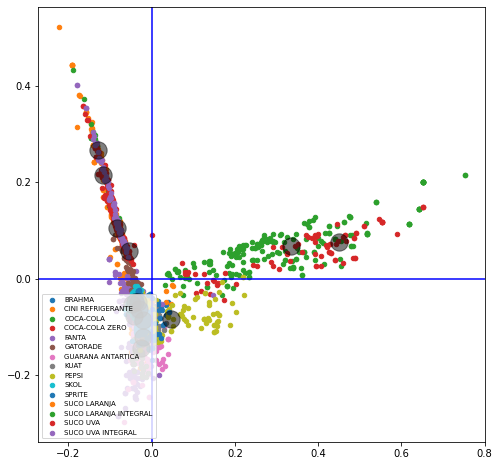

In [13]:
model = PCA(n_components=2)
transformed = model.fit_transform(X_train.todense(), y_train)
fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], cmap='tab20b', s=20, label = le.inverse_transform([g])[0])

centers = model.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', alpha=0.5)

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Termos por cluster

In [14]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(15):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ', '.join(top_ten_words)))

Cluster 0: peps, peps col, refr peps, refrig peps, twist, col, peps twist, l, refr, peps ml
Cluster 1: camp larg, camp, larg, suc camp larg, suc camp, suc, camp larg uva, larg uva, uva, larg laranj
Cluster 2: sprit, refrig sprit, sprit ml, refr sprit, ml, refrig, fresh, refr, sprit lt, lemon
Cluster 3: brahm, cerv brahm, cerv, cervej brahm, cervej, chopp, brahm chopp, ml, brahm ml, extr
Cluster 4: fant, fant laranj, refrig fant, refr fant, fant uva, ml, refrig, laranj, refr, fant ml
Cluster 5: uva, suc, gatorad, suc uva, ml, uva ml, l, uva l, vall, gatorad ml
Cluster 6: coc, coc col, col, coc col ml, col ml, refr coc, ml, refr coc col, refr, lat
Cluster 7: coc col zer, col zer, zer, coc col, col, coc, col zer ml, zer ml, ml, col zer l
Cluster 8: pur, pur malt, skol pur, malt, skol pur malt, skol, cerv skol pur, cerv skol, cerv, pur malt ml
Cluster 9: kuat, kuat ml, guar, refr kuat, guar kuat, kuat l, kuat guar, ml, refrig kuat, l
Cluster 10: guar, antarc, guar antarc, antar, refr guar,

#### Matriz de Confusão

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1227a9850>)

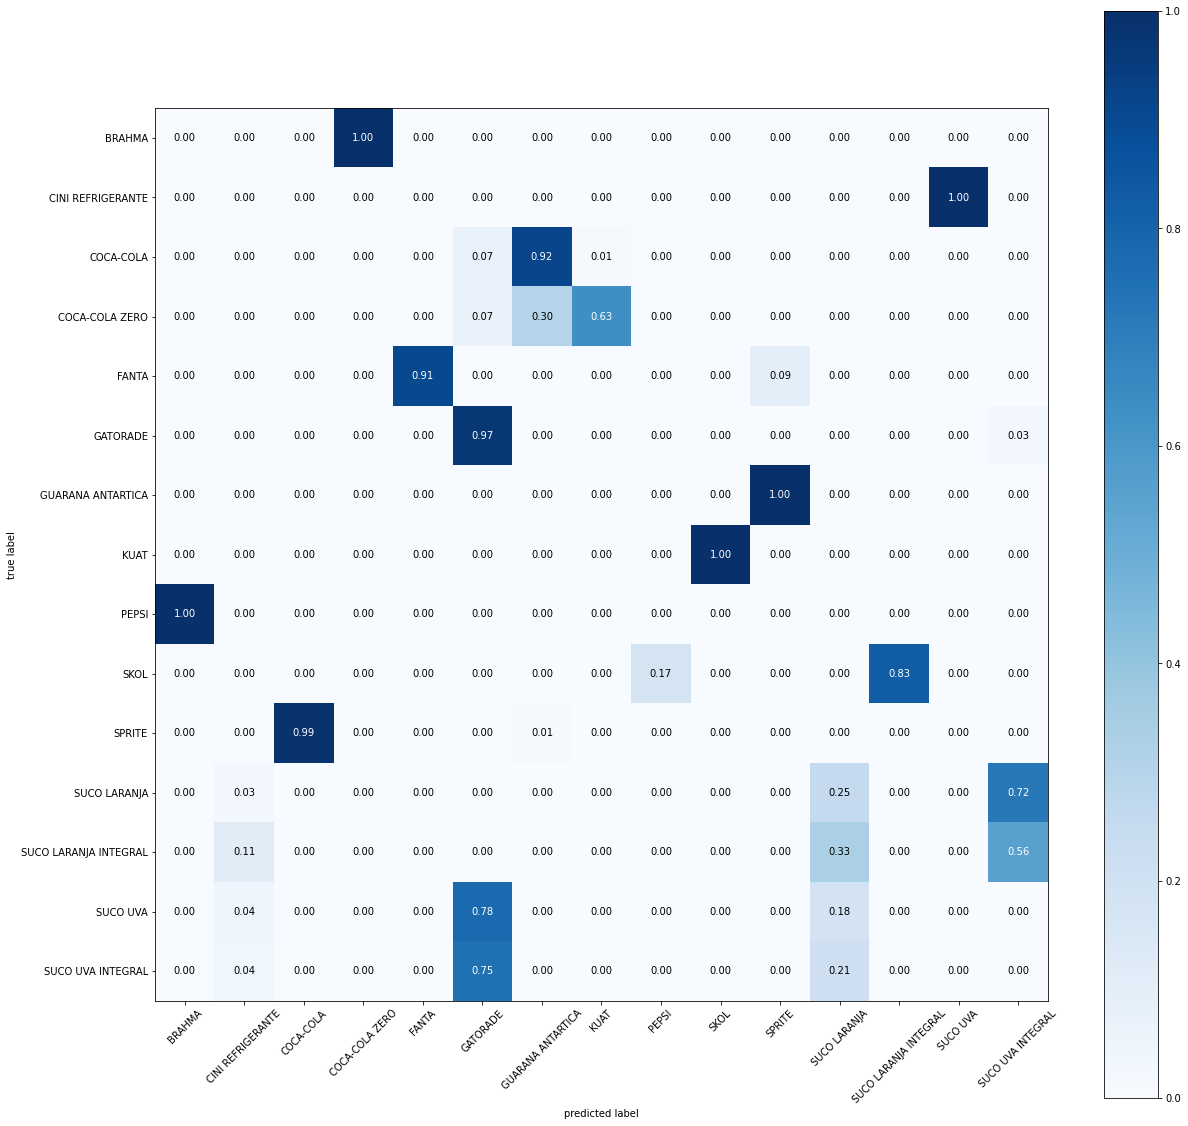

In [15]:
plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, Y_Pred),
    figsize=(20, 20),
    show_absolute=False,
    show_normed=True,
    colorbar=True,
    class_names=np.unique(le.inverse_transform(y_test))
)